In [1]:
import numpy as np
import matplotlib .pyplot as plt
from scipy.stats import multivariate_normal as smn
#from jax.scipy.stats import multivariate_normal as jmn
#from jax import random
import scipy
import jax.numpy as jnp
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
from jax import random
import numpyro

In [2]:
NP=10

In [3]:
smalla=1.0
smalldiag=smalla**2*jnp.identity(NP)

def modelcov(t,tau,a):
    fac=1.e-5
    Dt = t - jnp.array([t]).T
    amp=a
    K=amp*jnp.exp(-(Dt)**2/2/(tau**2))+amp*fac*jnp.identity(NP)
    return K


In [4]:
def RBF(t,tau):
    Dt = t - np.array([t]).T
    K=np.exp(-(Dt)**2/2/(tau**2))
    return K


In [5]:
ONEARR=jnp.zeros_like(NP)
xL=1.0
xarr=jnp.arange(0,xL,xL/NP)
xarr

DeviceArray([0.        , 0.1       , 0.2       , 0.3       , 0.4       ,
             0.5       , 0.6       , 0.7       , 0.8       , 0.90000004],            dtype=float32)

In [6]:
okey = random.PRNGKey(0)
#okey,key=random.split(okey)
cov=modelcov(xarr,2.0,1.0)
Tarr=numpyro.sample("Tarr", dist.MultivariateNormal(loc=ONEARR, covariance_matrix=cov),rng_key=okey)

In [7]:
def f(x,y):
    return y/(x+0.1)

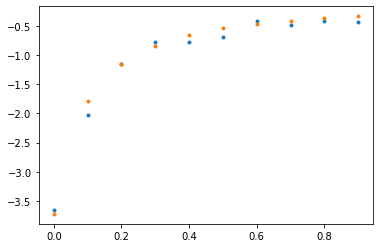

In [14]:
noise=np.random.normal(0.0,0.1,len(Tarr))
dobs=f(xarr,Tarr)+noise
plt.plot(xarr,dobs,".")
plt.plot(xarr,f(xarr,Tarr),".")
#plt.plot(xarr,Tarr+,".")

In [46]:
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist

def model(x,y):
    phase = numpyro.sample('phase', dist.Uniform(-0.5,0.5))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    #lntau = numpyro.sample('lntau', dist.Uniform(0.0,1.0))
    #tau=10**lntau
    #lna = numpyro.sample('lna', dist.Uniform(-1.0,1.0))
    #a=10**lna
    cov=modelcov(x,2.0,1.0)
    #cov=modelcov(x,tau,a)
    Tarr = numpyro.sample("Tarr", dist.MultivariateNormal(loc=ONEARR, covariance_matrix=cov))
    mu=Tarr/(x+phase)
    d=numpyro.sample('y', dist.Normal(mu, sigma), obs=y)
    return d

In [47]:
from jax import random
from numpyro.infer import MCMC, NUTS

# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)
num_warmup, num_samples = 1000, 2000
# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples)
mcmc.run(rng_key_, x=xarr, y=dobs)
mcmc.print_summary()

sample: 100%|████████████████████████████| 3000/3000 [01:08<00:00, 43.66it/s, 95 steps of size 4.40e-02. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Tarr[0]     -0.43      0.08     -0.42     -0.55     -0.31    260.28      1.00
   Tarr[1]     -0.42      0.06     -0.41     -0.51     -0.32    251.70      1.00
   Tarr[2]     -0.41      0.05     -0.40     -0.48     -0.33    251.27      1.00
   Tarr[3]     -0.40      0.04     -0.39     -0.46     -0.33    276.26      1.00
   Tarr[4]     -0.39      0.04     -0.38     -0.44     -0.33    326.89      1.00
   Tarr[5]     -0.38      0.04     -0.37     -0.42     -0.32    386.36      1.00
   Tarr[6]     -0.37      0.04     -0.37     -0.43     -0.32    429.27      1.00
   Tarr[7]     -0.36      0.04     -0.36     -0.45     -0.31    450.49      1.00
   Tarr[8]     -0.36      0.05     -0.36     -0.45     -0.27    460.67      1.00
   Tarr[9]     -0.35      0.07     -0.35     -0.46     -0.24    478.32      1.00
     phase      0.12      0.02      0.12      0.08      0.15    260.68      1.00
     sigma      0.13      0

In [17]:
samples = mcmc.get_samples()

In [19]:
Tsample=samples["Tarr"]

In [21]:
np.shape(Tsample)

(2000, 10)

In [35]:
from numpyro.diagnostics import hpdi
mean_muy = jnp.mean(Tsample, axis=0)
hpdi_muy = hpdi(Tsample, 0.90,axis=0)

In [36]:
np.shape(hpdi_muy)

(2, 10)

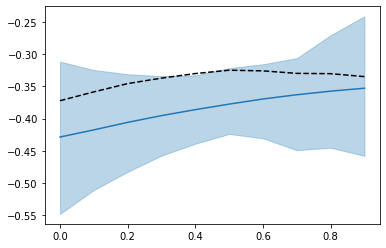

In [37]:
plt.plot(xarr,Tarr,color="black",ls="dashed")
plt.plot(xarr,mean_muy,color="C0")
plt.fill_between(xarr, hpdi_muy[0], hpdi_muy[1], alpha=0.3, interpolate=True,color="C0")

In [39]:
N=20
x=np.sort(np.random.rand(N))*4*np.pi
def modelc(x):
    phase = numpyro.sample('phase', dist.Uniform(-1.0*jnp.pi, 1.0*jnp.pi))
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu=jnp.sin(x+phase)
    d=numpyro.sample('y', dist.Normal(mu, sigma))
    return d

from numpyro import handlers
d = handlers.seed(modelc, rng_seed=9)(x)